# Introduction
This notebook is basic EDA for the `kc_house_data.csv` file. I create a data frame, do preliminary cleaning, and return a finished `cleaned_kc.csv` file to be used in the model training.

# Data Cleaning

## Importing Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import datetime  as dt
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
df = pd.read_csv('../data/kc_house_data.csv')

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


## Column Names And Meanings

In [4]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

Most of the column names make sense intuitively, or are explained decently in the supplementary `column_names.md` file. 

Columns `condition` and `grade` seem to be redundant, but [this](https://www.slideshare.net/PawanShivhare1/predicting-king-county-house-prices) project found through Kaggle asserts that `condition` speaks to the "condition of the apartment" and `grade` speaks to the "level of [building] construction and design." Still unclear, but I think that `condition` is more for a single unit and `condition` is for a whole apartment complex. Then again, the .csv file is named `house_data`. Hard to define a meaning here, but that doesn't mean these numbers are useless in analysis

In [5]:
df.view.describe()

count    21534.000000
mean         0.233863
std          0.765686
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: view, dtype: float64

Moreover, the `view` column does not make sense when compared to its description in `markdown.md`, which simply states "Has been viewed." This would imply a boolean column where **True** indicates having-been-viewed. Instead, the column is integers 0-4:

In [6]:
sorted(df.view.unique())

[0.0, nan, 1.0, 2.0, 3.0, 4.0]

Does this then indicate a *number of times* viewed instead of just yes-no? If so, why does it stop at 4? I would think personally that this 0-4 is actually a 1-5 rating system based on user reviews of a house showing. Either way, the column is almost entirely zeros, as seen below. I'm going to drop this column because of its ambiguity.

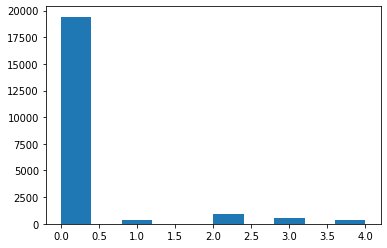

In [7]:
plt.hist(df.view);

In [8]:
df.drop('view', axis=1, inplace=True)

## Data Types

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(7), int64(11), object(2)
memory usage: 3.3+ MB


Some of these data types don't make sense and need to be changed. I will convert `date` to a date-time format and `sqft_basement` to a float. Column `sqft_basement` has an erroneous '?' value that also has to be accounted for.

In [10]:
print(sorted(df.sqft_basement.unique(), reverse=1)[0])

for a in ['?', '0.0']:
    print(len(df[df.sqft_basement == a]) / len(df) * 100)

?
2.1021438162707784
59.387877946011024


Only 2% of basement sizes are unknown. 59% of houses didn't have basements. The '?' values will be replaced with zeros. Then the whole column is cast as numeric (float).

In [11]:
no_qmark = df.sqft_basement.replace('?', '0.0')
df.sqft_basement = no_qmark

In [12]:
df.sqft_basement = pd.to_numeric(df.sqft_basement)

Now replace those date strings with the datetime data type and drop `date`, as datetime data would throw an error in our linear regression model later.

In [13]:
df['date'] = pd.to_datetime(df.date)
df['day_of_year'] = df['date'].dt.dayofyear
df['month'] = df['date'].dt.month
df.drop('date', axis=1, inplace=True)

In [14]:
df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,day_of_year,month
0,7129300520,221900.0,3,1.00,1180,5650,1.0,NaN,3,7,...,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,286,10
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,...,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,343,12
2,5631500400,180000.0,2,1.00,770,10000,1.0,0.0,3,6,...,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062,56,2
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,...,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,343,12
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,...,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,49,2


## Duplicates

In [15]:
dupe_rows = df[df.duplicated()]
len(dupe_rows)

0

No full-row duplicates in the data set. What about recycled ID's?

In [16]:
dupe_id = df[df.id.duplicated()]
print(len(dupe_id), np.round(1-(len(df)-len(dupe_id))/len(df), 2))

177 0.01


177 is a small percentage (0.01) of our data set. These may be houses that were resold. Either way, I will drop these rows because they are so few.

In [17]:
df.drop_duplicates(subset='id', inplace=True)

No other rows have values which would produce meaningful duplicates. In other words, things like `price`, `date`, and `waterfront` are not unique, and can be ignored here.

## Missing Values

In [18]:
np.sum(df.isna())

id                  0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2353
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3804
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
day_of_year         0
month               0
dtype: int64

The columns `waterfront` and `yr_renovated` both contain a decent number of NaN's. Let's look at their unique values and distributions to see how this should be addressed.

[nan  0.  1.]


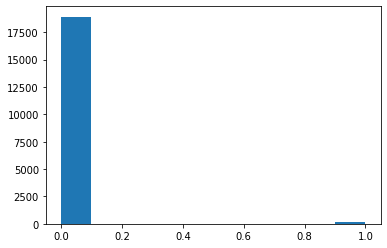

In [19]:
print(df.waterfront.unique())
plt.hist(df.waterfront);

This one's pretty straightforward. Those 2000-ish NaN's are becoming zeros.

In [20]:
df.waterfront.fillna(0, inplace=True)

Now what about `yr_renovated`?

In [21]:
renovated = df.yr_renovated[df.yr_renovated != 0]
print(len(renovated) / len(df.yr_renovated) * 100)

21.213818860877684


Only about 20% of houses have ever been renovated. It's smarter to turn this into a binary column (where 0 is "Has not been renovated" and 1 is "Has been renovated) than break it into dozens of dummy variables. Also, for NaN values, it is safer to assume that these houses have *not* been renovated, seeing as the mode of this column is 0, when cast as a binary option.

In [22]:
df.yr_renovated.fillna(0, inplace=True)

In [23]:
df.loc[(df.yr_renovated > 0), 'yr_renovated'] = 1

In [24]:
df.rename({'yr_renovated' : 'renovated'}, axis=1, inplace=True)

Double checking we got all the NaN's out of the data.

In [25]:
np.sum(df.isna())

id               0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
renovated        0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
day_of_year      0
month            0
dtype: int64

# Baseline Model

The data has been cleaned, but not transformed (i.e., continuous data not normalized, categorical data not made into dummies). The following baseline model will be used to judge any improvements made in the future.

In [26]:
price = df.price
indep = df.drop('price', axis = 1)

model = sm.OLS(price, indep).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     2536.
Date:                Mon, 20 Jul 2020   Prob (F-statistic):               0.00
Time:                        17:23:37   Log-Likelihood:            -2.9228e+05
No. Observations:               21420   AIC:                         5.846e+05
Df Residuals:                   21400   BIC:                         5.848e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
id            -1.069e-06   4.91e-07     -2.177      0.030   -2.03e-06   -1.06e-07
bedrooms      -4.006e+04   1928.792    -20.770      0.000   -4.38e+04   -3.63e+04
bathrooms      4.398e+04   3323.183     13.234      0.000    3.75e+04    5.05e+04
sqft_living     118.3180     18.320      6.459      0.000      82.410     154.226
sqft_lot          0.1597      0.049      3.283      0.001       0.064       0.255
floors         9980.9229   3603.333      2.770      0.006    2918.121     1.7e+04
waterfront     7.803e+05   1.72e+04     45.353      0.000    7.47e+05    8.14e+05
condition      2.846e+04   2369.397     12.013      0.000    2.38e+04    3.31e+04
grade          1.018e+05   2184.285     46.599      0.000    9.75e+04    1.06e+05
sqft_above       61.3234     18.302      3.351      0.001      25.451      97.196
sqft_basement    49.1460     18.164      2.706      0.007      13.542      84.750
yr_built      -2797.4569     68.026    -41.123      0.000   -2930.793   -2664.121
renovated      5.329e+04   8062.638      6.610      0.000    3.75e+04    6.91e+04
zipcode        -519.2070     18.197    -28.533      0.000    -554.874    -483.539
lat            5.766e+05   1.09e+04     52.971      0.000    5.55e+05    5.98e+05
long          -2.314e+05   1.33e+04    -17.354      0.000   -2.58e+05   -2.05e+05
sqft_living15    34.3616      3.418     10.053      0.000      27.662      41.061
sqft_lot15       -0.3842      0.075     -5.151      0.000      -0.530      -0.238
day_of_year    -460.9506    161.555     -2.853      0.004    -777.610    -144.292
month          1.085e+04   4913.763      2.207      0.027    1214.940    2.05e+04
==============================================================================
Omnibus:                    18038.770   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1709791.689
Skew:                           3.531   Prob(JB):                         0.00
Kurtosis:                      46.196   Cond. No.                     6.68e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.68e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The initial R-squared value is **0.692,** as is the adjusted R-squared. This is the value all subsequent models will be compared to.

# Multicollinearity

The function below changes the color of dataframe text if the correlation value is over a certain threshold. Here, that threshold is set to **0.75.** This will help the multicollinear pairs pop.

In [27]:
def redbool(val):
    if val == True:
        color = 'red'
    else:
        color = 'blue'
    return 'color: %s' % color

Applying it looks like this:

In [28]:
df_corr = abs(df.corr()) > 0.75
df_corr.style.applymap(redbool)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,renovated,zipcode,lat,long,sqft_living15,sqft_lot15,day_of_year,month
id,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
price,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,False,True,True,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False
sqft_lot,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
grade,False,False,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False


Highly-correlated pairs are now separated out in descending order:

In [29]:
# Create new DF
df_pairs = np.abs(df.corr()).stack().reset_index()

# Wrangle new DF to show pairs and correlation only
df_pairs['pairs'] = list(zip(df_pairs.level_0, df_pairs.level_1))
df_pairs.drop(columns=['level_1', 'level_0'], inplace = True)
df_pairs.set_index(['pairs'], inplace = True)
df_pairs.columns = ['cor']
df_pairs.drop_duplicates(inplace=True)

# Return high pairs and not self-correlations
df_pairs[(df_pairs.cor > .75) & (df_pairs.cor < 1.0)]

,cor
pairs,
"(bathrooms, sqft_living)",0.755522
"(sqft_living, grade)",0.762477
"(sqft_living, sqft_above)",0.876533
"(sqft_living, sqft_living15)",0.756186
"(grade, sqft_above)",0.756221
"(day_of_year, month)",0.995815


The first problem pair is `day_of_year` and `month`, for which the correlation is obvious. `month` gives us less dicrete information than `day_of_year` and also has a significantly higher p-value (0.027 as compared to 0.004), and is consequently the column to drop.

The next to go is `sqft_above`. It describes "square footage of house apart from basement" and is fairly redundant with `sqft_living`. Most homes don't have basements anyways, so this variable doesn't offer much.

Dropping `sqft_living` would "solve" the rest of the highly-correlated pairs, but is also *so* integral to buying a home that it seems inappropriate to remove. The correlation values for the pairs this variable is in are *pretty* close to the threshold, so they will be left as is.

In [30]:
df.drop(['month', 'sqft_above'], axis=1, inplace=True)

# Exporting Data

The data is now cleaned and can be exported to be handled in another notebook so things don't get too cluttered. All log transformations, normalizations, dummy-variable-creations, and the like will be handled in the notebook `model_training.ipynb`.

In [32]:
df.to_csv('../data/cleaned_kc.csv')

# Stuff For Blog Post: Ignore

In [33]:
df

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_basement,yr_built,renovated,zipcode,lat,long,sqft_living15,sqft_lot15,day_of_year
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,286
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,400.0,1951,1.0,98125,47.7210,-122.319,1690,7639,343
2,5631500400,180000.0,2,1.00,770,10000,1.0,0.0,3,6,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062,56
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,343
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,360000.0,3,2.50,1530,1131,3.0,0.0,3,8,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509,141
21593,6600060120,400000.0,4,2.50,2310,5813,2.0,0.0,3,8,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200,54
21594,1523300141,402101.0,2,0.75,1020,1350,2.0,0.0,3,7,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007,174
21595,291310100,400000.0,3,2.50,1600,2388,2.0,0.0,3,8,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287,16


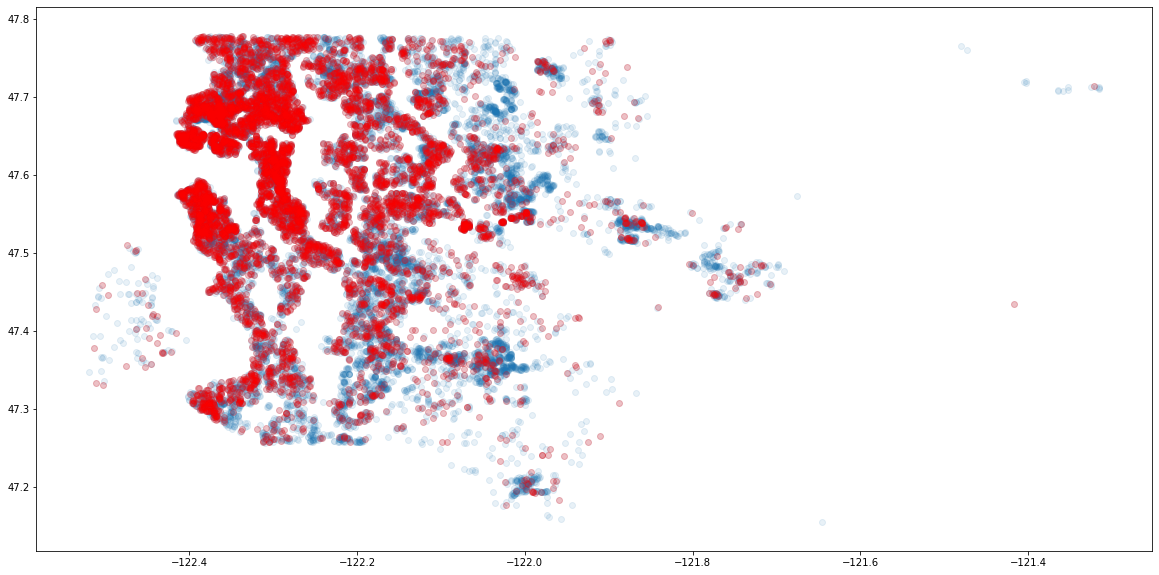

In [45]:
bsmt_df = df[df.sqft_basement > 0]
plt.figure(figsize=(20,10))
plt.scatter(df.long, df.lat, alpha=0.1)
plt.scatter(bsmt_df.long, bsmt_df.lat, color='r', alpha=0.2)

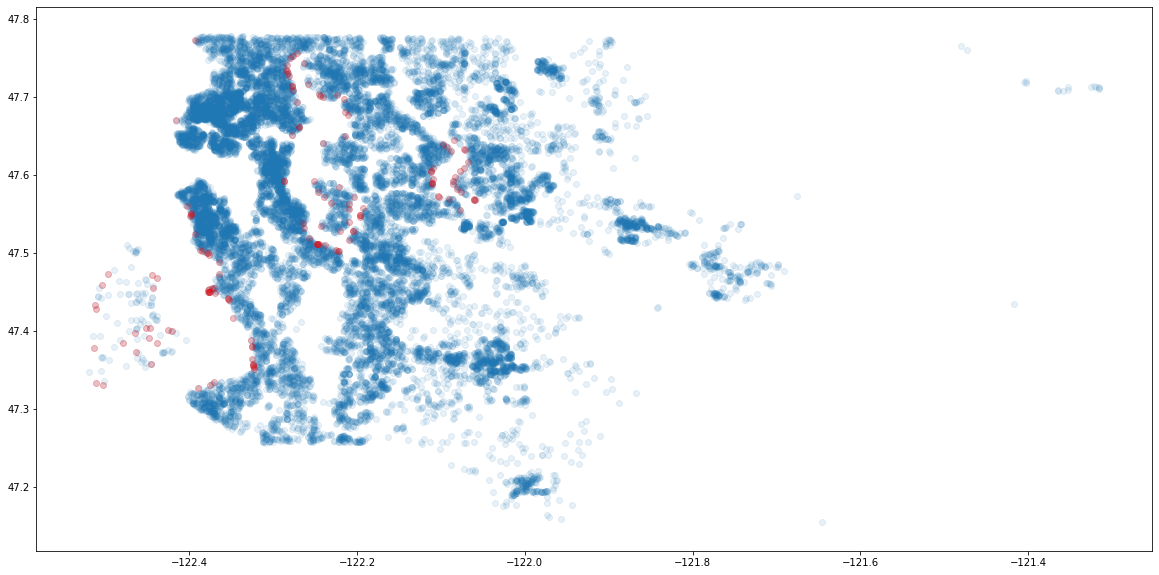

In [47]:
water_df = df[df.waterfront > 0]
plt.figure(figsize=(20,10))
plt.scatter(df.long, df.lat, alpha=0.1)
plt.scatter(water_df.long, water_df.lat, color='r', alpha=0.2)

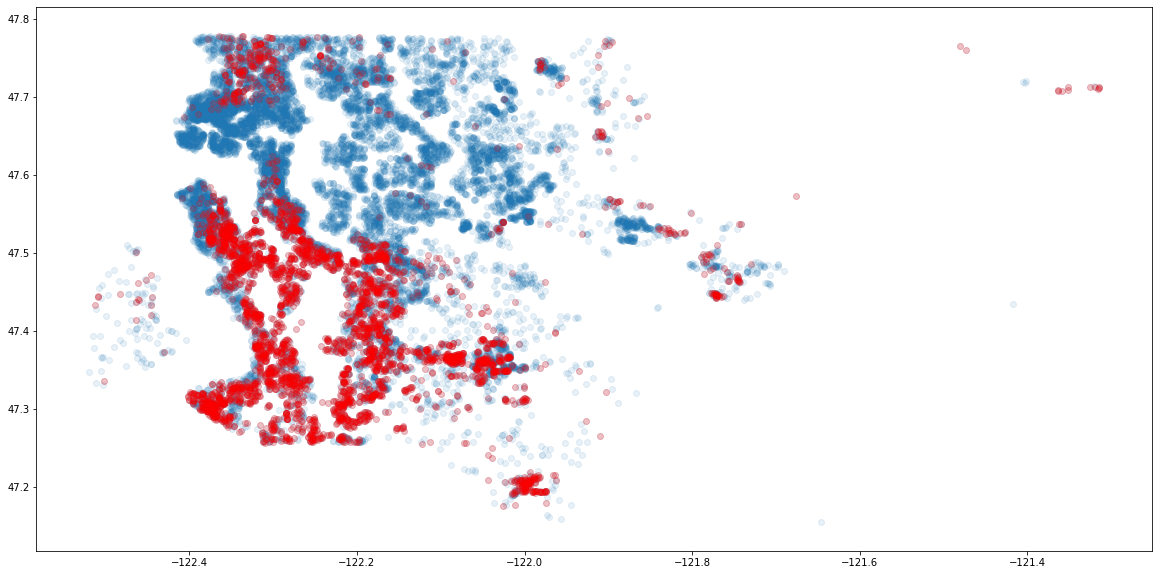

In [51]:
cheap_df = df[df.price < 300000]
plt.figure(figsize=(20,10))
plt.scatter(df.long, df.lat, alpha=0.1)
plt.scatter(cheap_df.long, cheap_df.lat, color='r', alpha=0.2)